In [1]:
from torchemotion.datasets.IemocapDataset import *
iemocap_dataset = IemocapDataset('/home/dstratton/IEMOCAP_full_release')

/tmp/ipykernel_4454/587072343.py:2: FutureWarning: Could not cast to float32, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  iemocap_dataset = IemocapDataset('/home/dstratton/IEMOCAP_full_release')


369


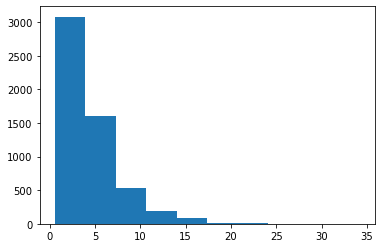

In [2]:
import matplotlib.pyplot as plt
plt.hist(iemocap_dataset.df["end"] - iemocap_dataset.df["start"])
print(sum(iemocap_dataset.df["end"] - iemocap_dataset.df["start"] > 10))
# remove super long clips
iemocap_dataset.df = iemocap_dataset.df[iemocap_dataset.df["end"] - iemocap_dataset.df["start"] < 10]

In [3]:
# todo: map labels to be in range [0, 4), since they aren't right now. maybe thats why nll loss is sad
mapping = dict([(y,x) for x,y in enumerate(sorted(set(iemocap_dataset.df["emotion"] )))])
iemocap_dataset.df["emotion"] = iemocap_dataset.df["emotion"].apply(lambda x: mapping[x])

In [4]:
# splitting into sets
import numpy as np, torch
# https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset
# todo: i could do this if i can rand seed it torch.utils.data.random_split(dataset, lengths, generator=<torch._C.Generator object>)
np.random.seed(0)
indices = np.arange(0, len(iemocap_dataset))
np.random.shuffle(indices)
train_indices = indices[:int(len(iemocap_dataset)*.8)]
val_indices = indices[int(len(iemocap_dataset)*.8):int(len(iemocap_dataset)*.9)]
test_indices = indices[int(len(iemocap_dataset)*.9):]
# train_set = torch.utils.data.Subset(iemocap_dataset, train_indices)
# val_set = torch.utils.data.Subset(iemocap_dataset, val_indices)
# test_set = torch.utils.data.Subset(iemocap_dataset, test_indices)
# todo: may be good to balance or at least check the balance

In [5]:
import pandas as pd
import librosa
import datasets

data_dict = {}
for split_name, indices in {"train": train_indices, "val": val_indices, "test": test_indices}.items():
    ind = 0
    df = pd.DataFrame(iemocap_dataset.df["emotion"].iloc[indices]).reset_index()
    # text
    # df['text'] = iemocap_dataset.df["transcription"]
    # audio
    df['audio'] = None
    for file_name in iemocap_dataset.df["file"].iloc[indices]:
        actual_file_name = '/home/dstratton/IEMOCAP_full_release/' + file_name
        s, r = librosa.load(actual_file_name, sr=16000)
        df['audio'][ind] = {'array': s, 'sampling_rate': r}
        ind += 1
    data_dict[split_name] = datasets.Dataset.from_pandas(df)

data = datasets.DatasetDict(data_dict)

/tmp/ipykernel_4454/2646199776.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['audio'][ind] = {'array': s, 'sampling_rate': r}


In [6]:
# audio
# base models
import transformers
# https://huggingface.co/facebook/wav2vec2-base
# 16 kHz sampling rate in original
processor = transformers.Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base", use_fast=True)
model = transformers.AutoModelForAudioClassification.from_pretrained("facebook/wav2vec2-base", num_labels=4).cuda()

/home/dstratton/miniconda3/envs/InterpretableMultimodal/lib/python3.9/site-packages/transformers/configuration_utils.py:336: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of the model checkpoint at facebook/wav2vec2-base were not used when initializing Wav2Vec2ForSequenceClassification: ['project_hid.bias', 'project_q.weight', 'quantizer.weight_proj.weight', 'quantizer.codevectors', 'project_q.bias', 'project_hid.weight', 'quantizer.weight_proj.bias']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected 

In [7]:
from transformers import AutoFeatureExtractor
# https://colab.research.google.com/github/huggingface/notebooks/blob/master/examples/audio_classification.ipynb#scrollTo=G1bX4lGAO_d9
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base")
feature_extractor

/home/dstratton/miniconda3/envs/InterpretableMultimodal/lib/python3.9/site-packages/transformers/configuration_utils.py:336: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": false,
  "sampling_rate": 16000
}

In [8]:
# https://huggingface.co/docs/datasets/audio_process.html
def prepare_dataset(batch):
    audio = batch["audio"]
    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    batch["labels"] = int(batch["emotion"])
    return batch

In [9]:
data = data.map(prepare_dataset,
                batch_size=1,
                remove_columns=['index'],
                # num_proc=4
                )

  0%|          | 0/4129 [00:00<?, ?ex/s]

  0%|          | 0/516 [00:00<?, ?ex/s]

  0%|          | 0/517 [00:00<?, ?ex/s]

In [13]:
import wandb
wandb.login()
%env WANDB_PROJECT=multimodal-emotion-rec

wandb: Currently logged in as: derekdstratton (use `wandb login --relogin` to force relogin)


env: WANDB_PROJECT=multimodal-emotion-rec


In [1]:
from transformers import Trainer, TrainingArguments
import numpy as np
from datasets import load_metric
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="iemocap-audio-model",
    group_by_length=True,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    report_to="wandb",
    num_train_epochs=20,
    learning_rate=1e-5,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    # save_strategy="no",
)

trainer = Trainer(
    model=model,
    # data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=data['train'],
    eval_dataset=data['val'],
    tokenizer=feature_extractor

    # tokenizer=processor,
    # tokenizer=tokenizer
)


KeyboardInterrupt



In [15]:
train_results = trainer.train()
wandb.finish()

The following columns in the training set  don't have a corresponding argument in `Wav2Vec2ForSequenceClassification.forward` and have been ignored: emotion, audio.
***** Running training *****
  Num examples = 4129
  Num Epochs = 20
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 20660
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/home/dstratton/miniconda3/envs/InterpretableMultimodal/lib/python3.9/site-packages/transformers/feature_extraction_utils.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180487213/work/torch/csrc/utils/tensor_new.cpp:201.)
  tensor = as_tensor(value)
/home/dstratton/miniconda3/envs/InterpretableMultimodal/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss


The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForSequenceClassification.forward` and have been ignored: emotion, audio.
***** Running Evaluation *****
  Num examples = 516
  Batch size = 4
Saving model checkpoint to iemocap-audio-model/checkpoint-1033
Configuration saved in iemocap-audio-model/checkpoint-1033/config.json
Model weights saved in iemocap-audio-model/checkpoint-1033/pytorch_model.bin
Configuration saved in iemocap-audio-model/checkpoint-1033/preprocessor_config.json
/home/dstratton/miniconda3/envs/InterpretableMultimodal/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForSequenceClassification.forward` and have been ignored: 

eval/accuracy,▁▁▃▂▄▄▇▆█▆▇▇█▇▇▇▇▇▇▇
eval/loss,▁▂▁▃▂▄▂▄▃▆▅▅▆▇▇▇████
eval/runtime,▁▃▃▄▄▅▆▆▅▆▆▇▅▅▆▆█▆▇█
eval/samples_per_second,█▆▆▅▅▄▃▃▄▃▃▂▄▄▃▃▁▃▂▁
eval/steps_per_second,█▆▆▅▅▄▃▃▄▃▃▂▄▄▃▃▁▃▂▁
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/learning_rate,███▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁
train/loss,█▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁


In [16]:
predictions = trainer.predict(data["test"])

# test_accuracy is correct, predictions for each class, you can take argmax
predictions.metrics

The following columns in the test set  don't have a corresponding argument in `Wav2Vec2ForSequenceClassification.forward` and have been ignored: emotion, audio.
***** Running Prediction *****
  Num examples = 517
  Batch size = 4
/home/dstratton/miniconda3/envs/InterpretableMultimodal/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'test_loss': 2.1163454055786133,
 'test_accuracy': 0.7330754352030948,
 'test_runtime': 20.8287,
 'test_samples_per_second': 24.822,
 'test_steps_per_second': 6.241}

In [20]:
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForSequenceClassification.forward` and have been ignored: audio, emotion.
***** Running Evaluation *****
  Num examples = 516
  Batch size = 4
/home/dstratton/miniconda3/envs/InterpretableMultimodal/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


{'eval_loss': 1.3443185091018677,
 'eval_accuracy': 0.35658914728682173,
 'eval_runtime': 20.5995,
 'eval_samples_per_second': 25.049,
 'eval_steps_per_second': 6.262}